In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import joblib
import pickle
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('clean_data.csv')

In [3]:
df.shape

(195, 10)

In [4]:
df.head()

,carat,x_dimension,y_dimension,z_dimension,depth,table,price,clarity,color,cut
0,0.500000,5.100000,5.150000,3.20000,61.5,56.637089,3000.0,if,d,ideal
1,0.700000,5.700000,5.701934,3.52000,62.0,59.000000,4500.0,vvs2,e,premium
2,0.183817,4.300000,4.310000,2.67548,62.3,56.000000,700.0,si2,h,good
3,1.200000,6.802001,6.820000,4.20000,61.7,58.000000,10000.0,if,d,ideal
4,0.900000,6.000000,5.997816,3.70000,61.7,56.969121,2400.0,i1,j,fair


In [5]:
df.describe()

,carat,x_dimension,y_dimension,z_dimension,depth,table,price
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.801808,5.879414,5.881751,3.641982,62.332610,56.873305,5332.206491
std,0.307975,0.766318,0.769802,0.473890,0.278007,1.304718,3276.837132
min,0.183817,3.900000,3.890000,2.410000,61.200000,54.000000,327.281257
25%,0.550000,5.300000,5.302846,3.290000,62.200000,56.000000,2600.000000
50%,0.800000,5.900000,5.890000,3.650000,62.359353,57.000000,4200.000000
75%,1.050000,6.500000,6.520000,4.035000,62.500000,58.000000,7900.000000
max,1.600000,7.300000,7.280000,4.500000,63.000000,60.000000,18361.965283


## Wizualizacje danych

In [6]:
numeric_columns = ['carat', 'x_dimension', 'y_dimension', 'z_dimension', 'depth', 'table', 'price']

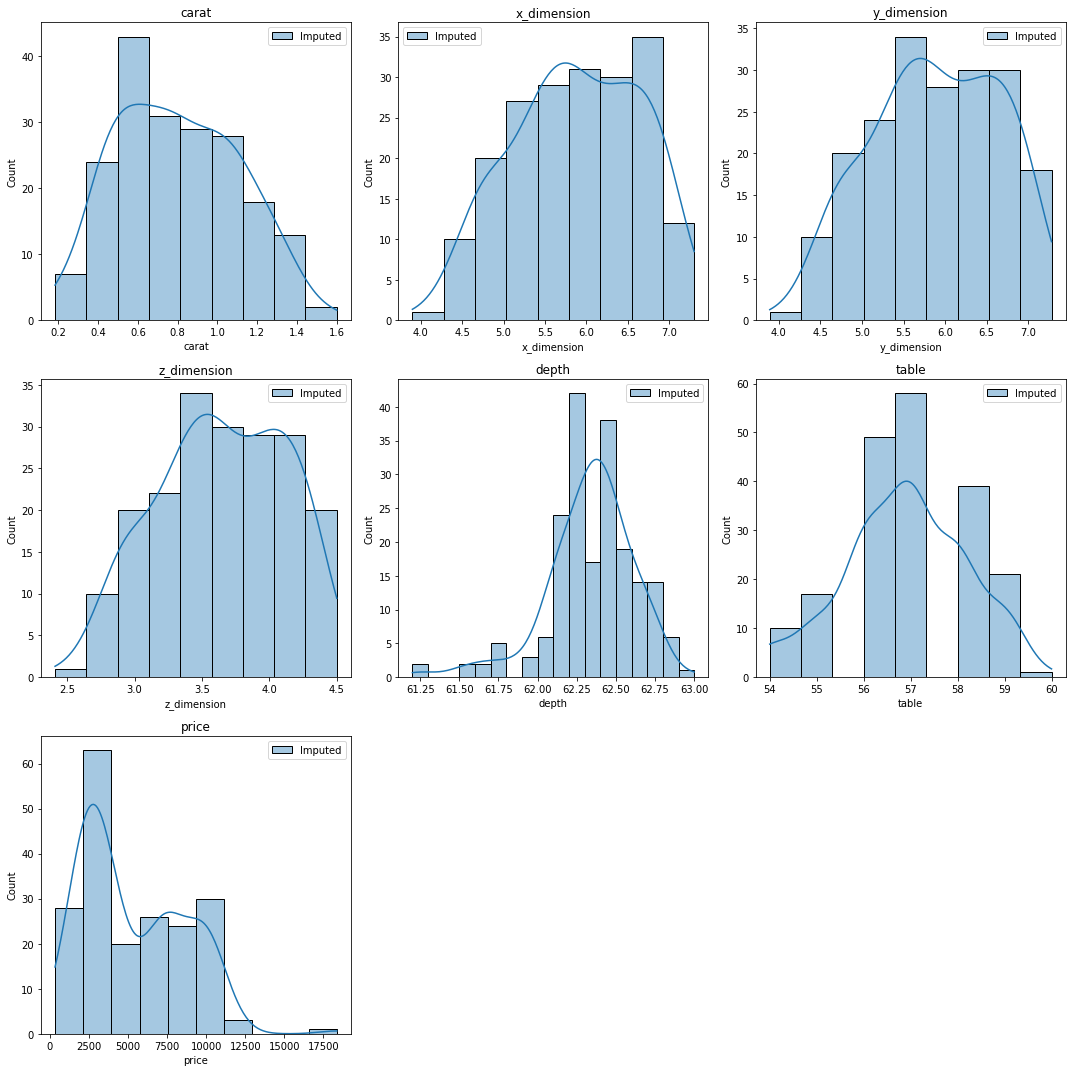

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], ax=axes[i], label='Imputed', kde=True, alpha=0.4)
    axes[i].set_title(col)
    axes[i].legend()

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.tight_layout()
plt.show()

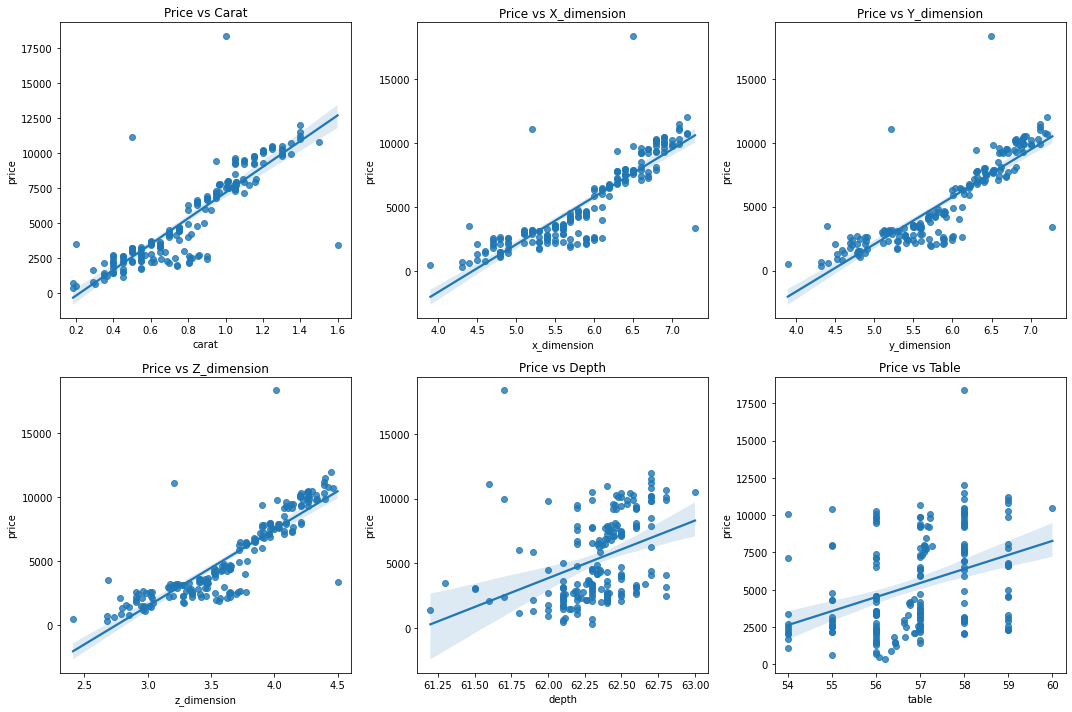

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
numeric_columns_except_price = [col for col in numeric_columns if col != 'price']

for i, col in enumerate(numeric_columns_except_price):
    sns.regplot(x=col, y='price', data=df, ax=axes[i])
    axes[i].set_title(f'Price vs {col.capitalize()}')

plt.tight_layout()
plt.show()

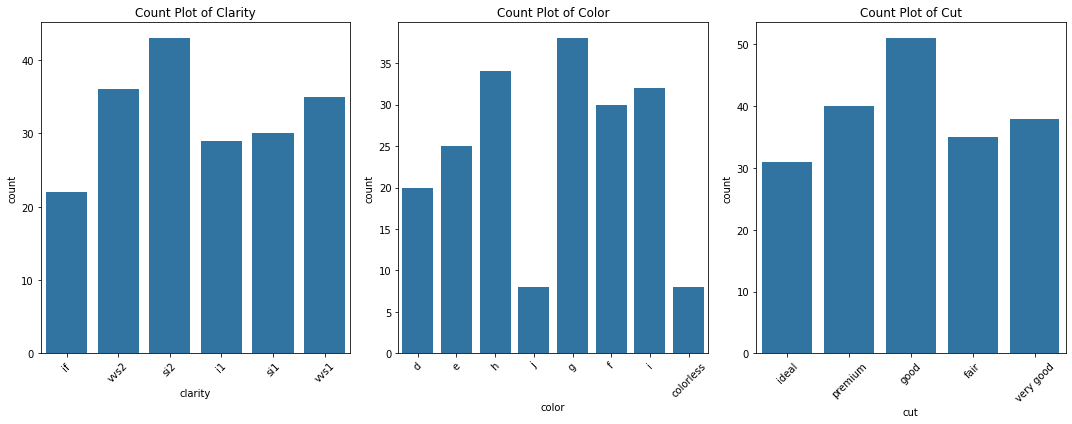

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
categorical_columns = ['clarity', 'color', 'cut']

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Count Plot of {col.capitalize()}')
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

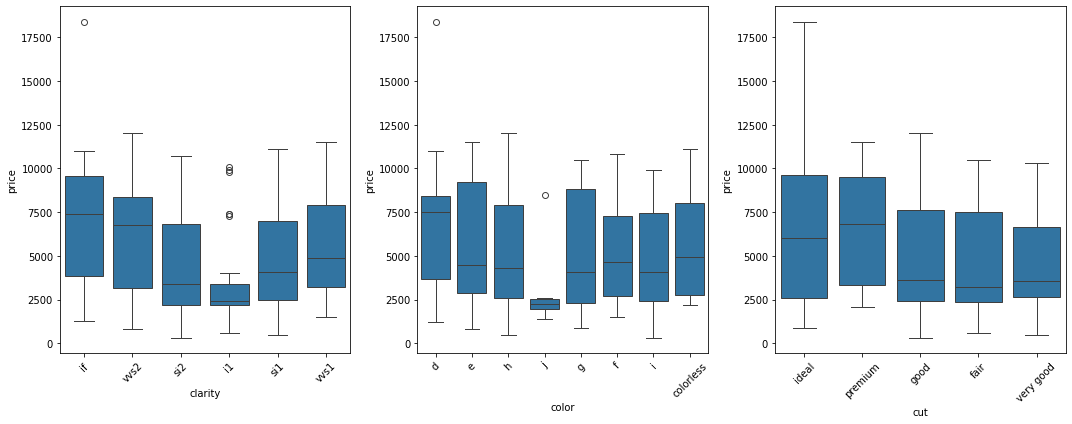

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='price', data=df, ax=axes[i])
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

## Modelowanie

### Podział zbioru

In [11]:
df_dummies = df.copy()
df_dummies = pd.get_dummies(df, drop_first=True, dtype='int')
df_dummies.columns = [col.replace(' ', '_').replace('.', '_') for col in df_dummies.columns]
train, test = train_test_split(df_dummies, test_size=0.3, random_state=0)

In [12]:
train.head()

,carat,x_dimension,y_dimension,z_dimension,depth,table,price,clarity_if,clarity_si1,clarity_si2,...,color_e,color_f,color_g,color_h,color_i,color_j,cut_good,cut_ideal,cut_premium,cut_very_good
149,0.40,4.8,4.780000,2.957591,62.400000,58.0,2100.0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
180,1.05,6.6,6.650000,4.110000,62.444151,58.0,9200.0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
54,1.30,6.9,6.904515,4.260000,62.300000,57.0,9900.0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
159,0.75,5.9,5.910000,3.660000,62.300000,59.0,4600.0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
16,0.50,5.2,5.177885,3.200000,62.222724,56.0,2300.0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


In [13]:
test.head()

,carat,x_dimension,y_dimension,z_dimension,depth,table,price,clarity_if,clarity_si1,clarity_si2,...,color_e,color_f,color_g,color_h,color_i,color_j,cut_good,cut_ideal,cut_premium,cut_very_good
83,0.972758,6.3,6.320000,3.920000,62.409393,57.0,7800.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12,0.741672,5.7,5.710000,3.540000,62.362187,54.0,2000.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
33,1.201653,6.9,6.904754,4.270000,62.200000,57.0,9300.0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
113,1.200000,6.9,6.890000,4.272083,62.800000,54.0,10100.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
171,0.500000,5.2,5.197887,3.220000,62.100000,57.0,3100.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


### Forward selection i backward elimination - p-wartość

Najpierw wybierzemy zmienne na podstawie p-wartości.

In [14]:
# Forward selection with pvalue criteria
def forward_selection_pval(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        pvalues = []
        for candidate in remaining:
            formula = '{} ~ {}'.format(response, ' + '.join(selected + [candidate]))
            current_pval = ols(formula, data).fit().pvalues[candidate]
            pvalues.append((current_pval, candidate))
        pvalues.sort()
        smallest_pval, best_candidate = pvalues.pop(0)
        if smallest_pval < 0.05:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
        else:
            break
    formula = '{} ~ {}'.format(response, ' + '.join(selected))
    model = ols(formula, data).fit()
    return model

# Backward elimination with pvalue criteria
def backward_elimination_pval(data, response):
    features = data.columns.tolist()
    features.remove(response)
    while True:
        formula = '{} ~ {}'.format(response, ' + '.join(features))
        model = ols(formula, data).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > 0.05:
            worst_feature = pvalues.idxmax()
            features.remove(worst_feature)
        else:
            break
    formula = '{} ~ {}'.format(response, ' + '.join(features))
    model = ols(formula, data).fit()
    return model


model_forward = forward_selection_pval(train, 'price')
model_backward = backward_elimination_pval(train, 'price')

model_forward.summary(), model_backward.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  price   R-squared:                       0.835
 Model:                            OLS   Adj. R-squared:                  0.824
 Method:                 Least Squares   F-statistic:                     80.11
 Date:                Sat, 03 Feb 2024   Prob (F-statistic):           6.53e-46
 Time:                        17:13:16   Log-Likelihood:                -1172.8
 No. Observations:                 136   AIC:                             2364.
 Df Residuals:                     127   BIC:                             2390.
 Df Model:                           8                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

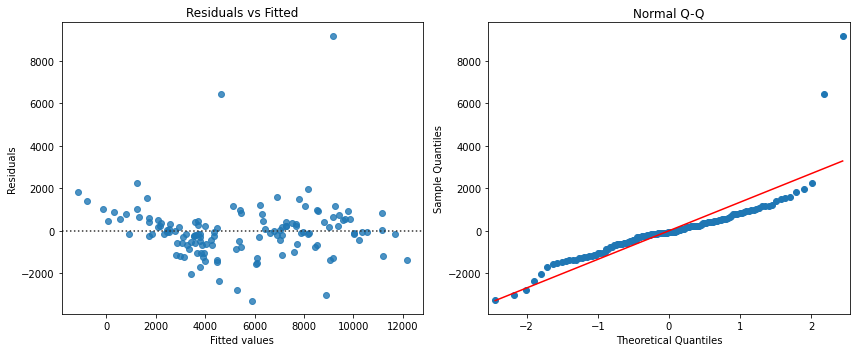

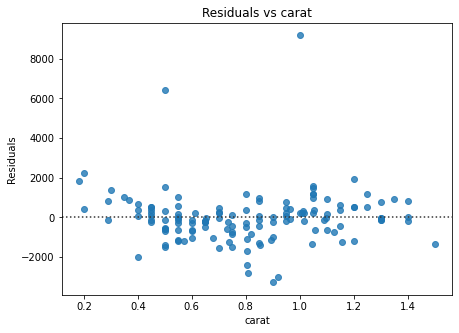

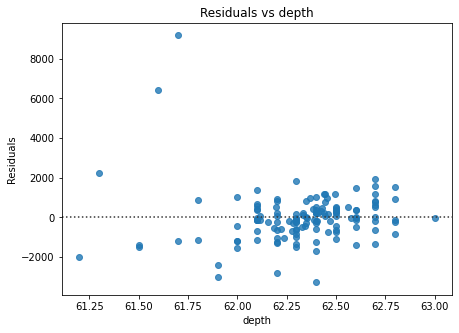

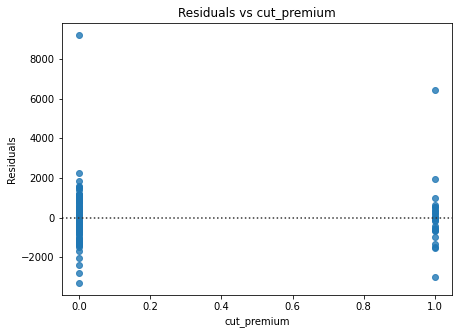

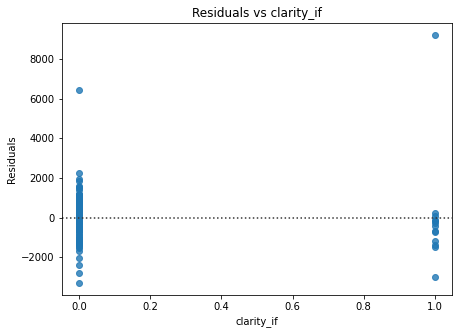

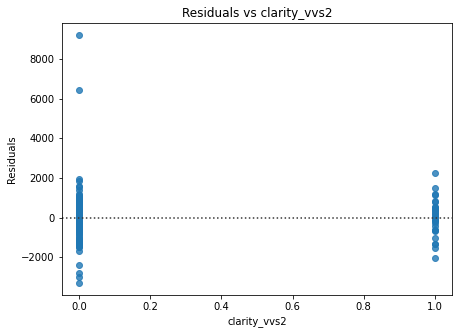

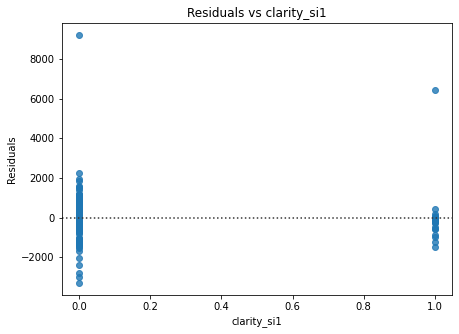

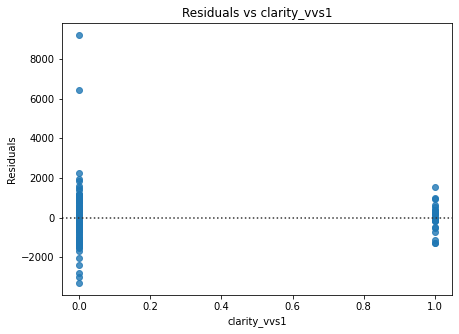

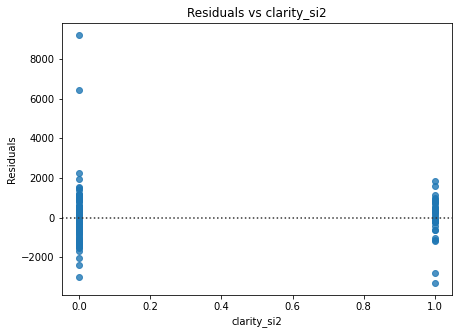

In [15]:
# Function to create residual plots
def create_residual_plots(model, data, predictors):
    # Calculate residuals
    fitted_vals = model.predict()
    residuals = model.resid

    # Residuals vs Fitted values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.residplot(x=fitted_vals, y=residuals, line_kws={'color': 'red', 'lw': 1})
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    
    # Q-Q plot
    plt.subplot(1, 2, 2)
    sm.qqplot(residuals, line='s', ax=plt.gca())
    plt.title('Normal Q-Q')
    plt.tight_layout()

    # Residuals vs Predictors
    for predictor in predictors:
        plt.figure(figsize=(7, 5))
        sns.residplot(x=data[predictor], y=residuals, line_kws={'color': 'red', 'lw': 1})
        plt.title(f'Residuals vs {predictor}')
        plt.xlabel(predictor)
        plt.ylabel('Residuals')

# Extract predictors used in the forward selection model
predictors_forward = model_forward.model.exog_names.copy()
predictors_forward.remove('Intercept')

create_residual_plots(model_forward, train, predictors_forward)

In [16]:
def actual_vs_predicted_plot(model, y, df):
    y_pred = model.predict(df)
    # Plotting the actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.title('Actual vs Predicted Price')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Diagonal line
    plt.show()

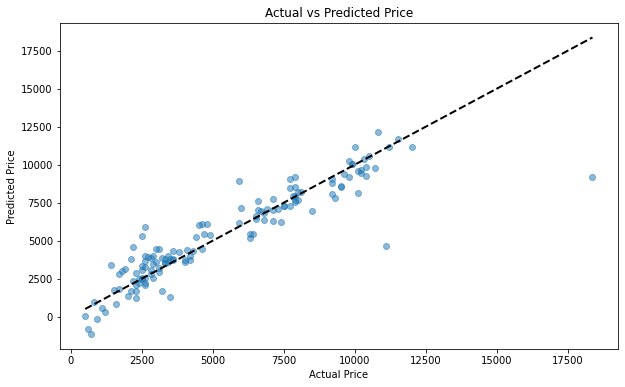

In [17]:
actual_vs_predicted_plot(model_forward, train['price'], train)

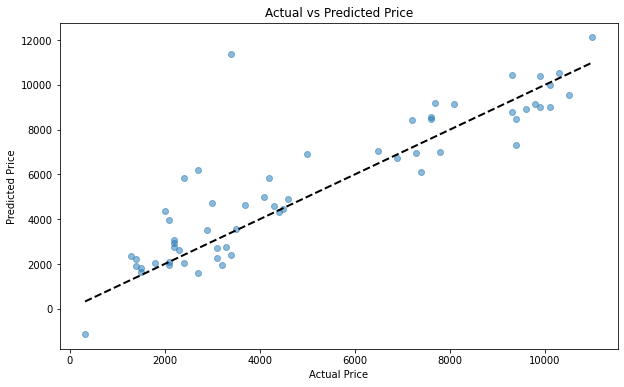

In [18]:
actual_vs_predicted_plot(model_forward, test['price'], test)

In [19]:
model_forward.resid.sort_values()

32    -3279.517111
41    -3009.583838
64    -2778.856455
39    -2376.050630
11    -2016.890929
          ...     
2      1845.880889
179    1955.283380
15     2233.754689
10     6446.446383
17     9184.954079
Length: 136, dtype: float64

In [20]:
train.loc[[10, 17]]

,carat,x_dimension,y_dimension,z_dimension,depth,table,price,clarity_if,clarity_si1,clarity_si2,...,color_e,color_f,color_g,color_h,color_i,color_j,cut_good,cut_ideal,cut_premium,cut_very_good
10,0.5,5.199509,5.21,3.210000,61.6,58.0,11102.189775,0,1,0,...,0,0,0,0,0,0,0,0,1,0
17,1.0,6.500000,6.49,4.013331,61.7,58.0,18361.965283,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
# Export pvalue models
with open(f'models/model_forward_p_value.pkl', 'wb') as f:
    pickle.dump(model_forward, f)
with open(f'models/model_backward_p_value.pkl', 'wb') as f:
    pickle.dump(model_backward, f)
    
print('Exported')

Exported


### AIC, BIC, Adj $R^2$

Tym razem spróbujemy wybrać model używając kryteriów AIC, BIC, i adj-$R^2$

In [22]:
def forward_selection(data, response, criterion='adj_rsquare'):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('-inf'), float('-inf')
    while remaining and current_score==best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = '{} ~ {}'.format(response, ' + '.join(selected + [candidate]))
            score = evaluate_model(data, formula, criterion)
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = '{} ~ {}'.format(response, ' + '.join(selected))
    model = ols(formula, data).fit()
    return model, formula


def backward_elimination(data, response, criterion='adj_rsquare'):
    features = list(set(data.columns) - {response})
    current_score = evaluate_model(data, '{} ~ {}'.format(response, ' + '.join(features)), criterion)
    best_new_score = current_score
    while features and current_score <= best_new_score:
        scores_with_candidates = []
        for candidate in features:
            formula = '{} ~ {}'.format(response, ' + '.join(set(features) - {candidate}))
            score = evaluate_model(data, formula, criterion)
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, worst_candidate = scores_with_candidates.pop()
        if current_score <= best_new_score:
            features.remove(worst_candidate)
            current_score = best_new_score
    formula = '{} ~ {}'.format(response, ' + '.join(features))
    model = ols(formula, data).fit()
    return model, formula

# Evaluate a model based on the chosen criterion
def evaluate_model(data, formula, criterion):
    model = ols(formula, data).fit()
    if criterion == 'adj_rsquare':
        return model.rsquared_adj
    elif criterion == 'aic':
        return -model.aic
    elif criterion == 'bic':
        return -model.bic
    else:
        raise ValueError('Unknown criterion')

In [23]:
response_variable = 'price'
criteria = ['aic', 'bic', 'adj_rsquare']

for criterion in criteria:
    model_forward, _ = forward_selection(train, response_variable, criterion)
    model_backward, _ = backward_elimination(train, response_variable, criterion)
    with open(f'models/model_forward_{criterion}.pkl', 'wb') as f:
        pickle.dump(model_forward, f)
    with open(f'models/model_backward_{criterion}.pkl', 'wb') as f:
        pickle.dump(model_backward, f)

print('Models trained and saved.')

Models trained and saved.


In [24]:
# Export train and test sets
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)